In [1]:

import numpy as np
import scipy as sp
import scipy.sparse
import pandas as pd
import os
import bbknn

import anndata as ad

import scanpy

import matplotlib.pyplot as plt
import tensorflow as tf
import scgen

import hummingbird as hbdx

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# settings
adata_path = "/data/hbdx/test_classifynder/data/LC__ngs__raw-current.h5ad"
n_features = 2500
#holdout_batches = ["essen_201220_hbdx_pool1_A1", "210208__468_Pool3__hbdx"]
holdout_batches = ["konstanz_201208_hbdx_pool1", "Boston_Pool3"]

model_path = f"./models/batch{n_features}_{'-'.join(holdout_batches)}"
force_training = True


plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [4]:
def get_data(adata_path, batch_col="Lab_Multiplexing_pool_ID", cell_col="Gender", condition_col="Diagnosis_Group"):
    adata = hbdx.io.load(adata_path)

    pool_id_mapping = {label:f"pool{i}" for i, label in enumerate(adata.obs.Lab_Multiplexing_pool_ID.unique())}
    adata.obs["Lab_Multiplexing_pool_ID_simple"] = adata.obs.Lab_Multiplexing_pool_ID.map(pool_id_mapping)
    
    
    adata.obs["gender_diagnosis"] = adata.obs.apply(lambda x: x["Gender"]+"__" +x["Diagnosis_Group"], axis=1)
    
    adata.obs["batch"] = adata.obs[batch_col]

    adata.obs["cell_type"] = adata.obs[cell_col] if not cell_col is None else "blood"
    
    adata.obs["condition"] = adata.obs[condition_col]

    adata = adata[adata.obs["Sample_Group"]=="Study"].copy()
    
    return adata

def apply_preprocessing(adata, feature_selection=False, n_top_genes=2000):
    adata = adata.copy()
    adata.raw = adata.copy()
    
    scanpy.pp.calculate_qc_metrics(adata, inplace=True)
    scanpy.pp.normalize_total(adata, target_sum=1e6)
    scanpy.pp.log1p(adata)
    
    scanpy.pp.scale(adata)
    scanpy.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

    adata = adata[adata.obs.n_genes_by_counts > 5, :]
    
    if feature_selection:
        adata = adata[:, adata.var.highly_variable]
    
    scanpy.tl.pca(adata)
    scanpy.pp.neighbors(adata)
    scanpy.tl.umap(adata)
    
    return adata

In [5]:
# Load AnnData

adata = get_data(adata_path,
                 batch_col="Lab_Multiplexing_pool_ID", 
                 cell_col=None,#"Gender",
                 condition_col="Diagnosis_Group")

In [6]:
#batches
print(adata.obs.batch.value_counts())

Thorax_Set1                   92
Thorax_Set2                   92
essen_210104_hbdx_pool2_A2    86
essen_201220_hbdx_pool1_A1    86
Thorax_Pool1_D1               86
                              ..
Konstanz_Pool1                27
210208__468_Pool3__hbdx       23
210128__468_Pool4__hbdx       18
Kempten_Pool1                 11
Kempten_Pool2                 10
Name: batch, Length: 28, dtype: int64


In [7]:
adata_train = apply_preprocessing(adata[~adata.obs.batch.isin(holdout_batches), :], 
                                  feature_selection=True, 
                                  n_top_genes=n_features)

In [8]:
adata_test = apply_preprocessing(adata[adata.obs.batch.isin(holdout_batches), :], 
                                 feature_selection=False)

In [9]:
adata_test = adata_test[:, adata_train.var_names]

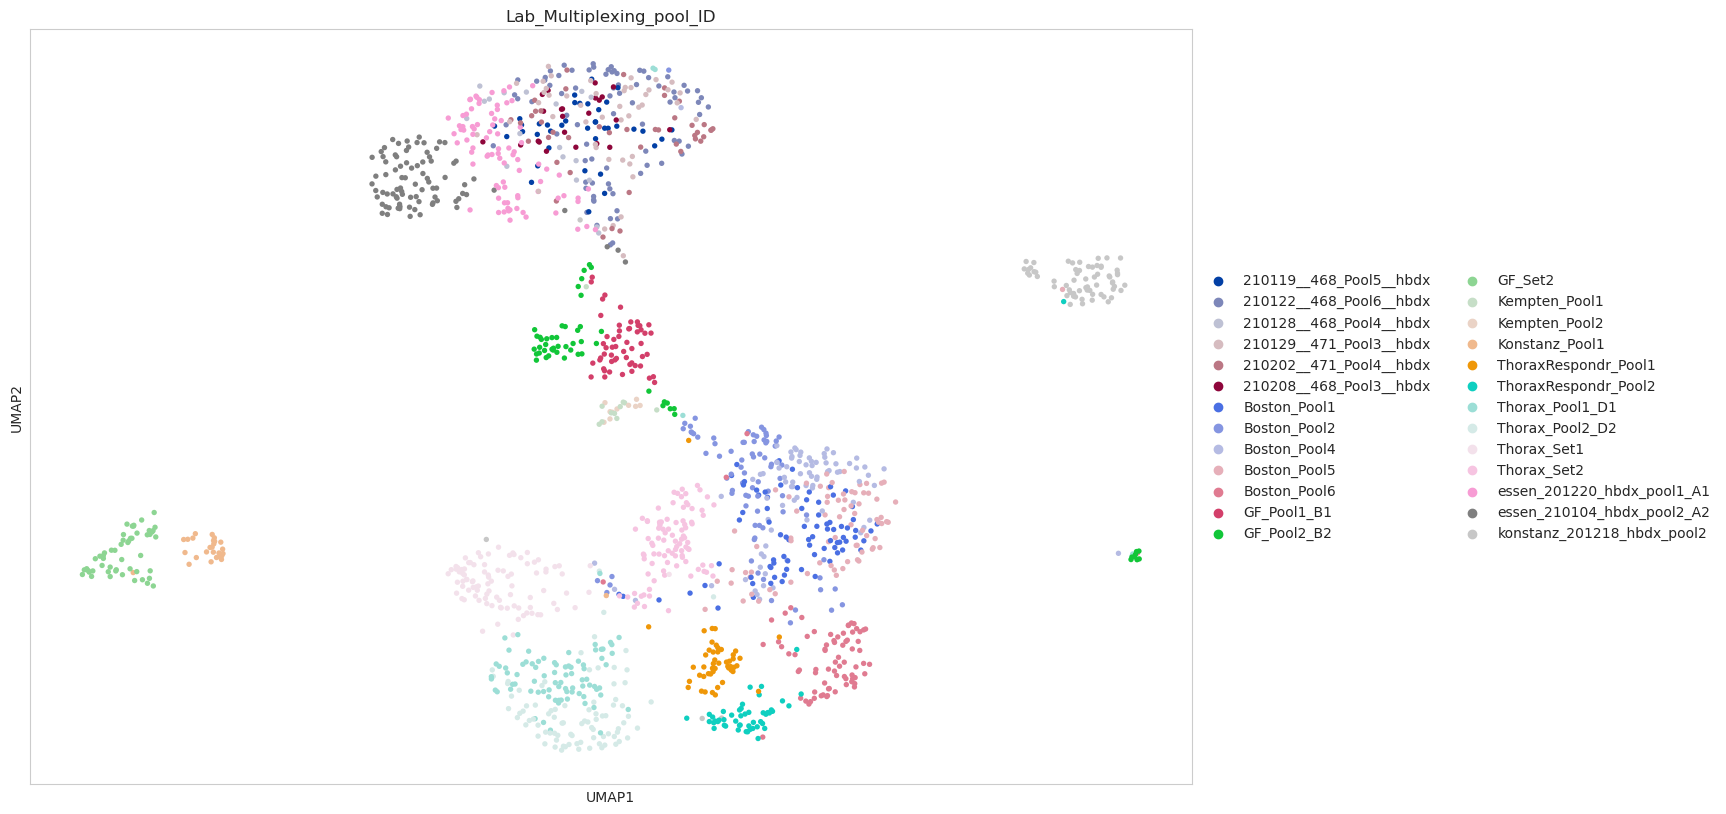

In [10]:
scanpy.pl.umap(adata_train, color=["Lab_Multiplexing_pool_ID"], ncols=1, size=60)

In [11]:
# train / load the VAE
network = scgen.VAEArithKeras(x_dimension= n_features, 
                              model_path=model_path, 
                              z_dimension=100, 
                              alpha=0.5, 
                              learning_rate=0.001,
                              dropout_rate=0.5)

if os.path.exists(model_path) and not force_training:
    network.restore_model()# need h5py version 2.10 for this !!!!
else:
    network.train(train_data=adata_train, n_epochs=100)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2500)]            0         
_________________________________________________________________
encoder (Functional)         (None, 100)               2806600   
_________________________________________________________________
decoder (Functional)         (None, 2500)              2728900   
Total params: 5,535,500
Trainable params: 5,529,100
Non-trainable params: 6,400
_________________________________________________________________
Epoch 1/100


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-11-b7e81267f6a5>:12 in <module>                                            │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scgen/models/_vae_keras.py:516 in   │
│ train                                                                                     │
│                                                                                           │
│   513 │   │   │   │   │   │   │   │   │   │   callbacks=callbacks,                        │
│   514 │   │   │   │   │   │   │   │   │   │   verbose=verbose)                            │
│   515 │   │   else:                                                                       │
│ ❱ 516 │   │   │   result = self.vae_model.fit(x=train_data.X,                             │
│   517 │   │   │   │   │   │   │   │   │   │   y=train_data.X,                             │
│   518 │   │   │   │   │   │   │   │   │   │   epochs=n_epochs,                            │
│   519 │   │   │   │   │   │   │   │   │   │   batch_size=batch_size,                      │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/tensorflow/python/keras/engine/trai │
│ ning.py:1100 in fit                                                                       │
│                                                                                           │
│   1097 │   │   │   │   batch_size=batch_size,                                             │
│   1098 │   │   │   │   _r=1):                                                             │
│   1099 │   │   │     callbacks.on_train_batch_begin(step)                                 │
│ ❱ 1100 │   │   │     tmp_logs = self.train_function(iterator)                             │
│   1101 │   │   │     if data_handler.should_sync:                                         │
│   1102 │   │   │   │   context.async_wait()                                               │
│   1103 │   │   │     logs = tmp_logs  # No error, now safe to assign to logs.             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/tensorflow/python/eager/def_functio │
│ n.py:828 in __call__                                                                      │
│                                                                                           │
│    825 │                                                                                  │
│    826 │   tracing_count = self.experimental_get_tracing_count()                          │
│    827 │   with trace.Trace(self._name) as tm:                                            │
│ ❱  828 │     result = self._call(*args, **kwds)                                           │
│    829 │     compiler = "xla" if self._experimental_compile else "nonXla"                 │
│    830 │     new_tracing_count = self.experimental_get_tracing_count()                    │
│    831 │     without_tracing = (tracing_count == new_tracing_count)                       │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/tensorflow/python/eager/def_functio │
│ n.py:871 in _call                                                                         │
│                                                                                           │
│    868 │   try:                                                                           │
│    869 │     # This is the first call of __call__, so we have to initialize.              │
│    870 │     initializers = []                                                            │
│ ❱  871 │     self._initialize(args, kwds, add_init

In [ ]:
train_log = pd.read_csv("/home/tos/code/classifynder/csv_logger.log")
train_log.iloc[:,1:].plot()

In [ ]:
corrected_train =  scgen.batch_removal(network, 
                                       adata_train, 
                                       batch_key="batch", 
                                       cell_label_key="cell_type")
corrected_train.raw = adata_train

In [ ]:
scanpy.pp.neighbors(corrected_train)
scanpy.tl.umap(corrected_train)
scanpy.pl.umap(corrected_train, color=[
    "batch",
    "cell_type",
    "Diagnosis_Group", 
    "Diagnosis_Group_sub",
    "TumStage",
    "Age",
    "Packyears", 
    "ProjectName", 
    "Site_Clinic",
    "Gender"
], ncols=2,frameon=False, use_raw=False)

In [ ]:
scanpy.pl.umap(adata_test, color=["batch","cell_type"], ncols=1,frameon=True)

In [ ]:
#adata_test_unlab = adata_test.copy()

#adata_test_unlab.obs.cell_type = 0
#print(adata_test_unlab.obs.cell_type.value_counts())
corrected_test = scgen.batch_removal(network, adata_test, batch_key="batch", )
corrected_test.raw = adata_test

#corrected_test.obs.cell_type = adata_test.obs.cell_type

In [ ]:
corrected_merged = ad.concat([corrected_train, corrected_test])

In [ ]:
holdout_batches

In [ ]:
scanpy.pp.neighbors(corrected_merged)
scanpy.tl.umap(corrected_merged)
scanpy.pl.umap(corrected_merged, color=["batch","cell_type","condition"], ncols=1,frameon=False, use_raw=False)

In [ ]:
scanpy.pl.umap(corrected_merged, color=["batch"], groups=holdout_batches, ncols=1,frameon=False)

In [ ]:
train_adata_cancer = corrected_train[corrected_train.obs.condition=="CaseLC"]
train_adata_control = corrected_train[corrected_train.obs.condition=="Control"]

In [ ]:
print(train_adata_cancer)
print(train_adata_control)

In [ ]:
pred, delta = network.predict(adata=train_adata_cancer, 
                              conditions={"ctrl": "Control", "stim": "CaseLC"}, 
                              adata_to_predict=train_adata_control,
                              cell_type_key="cell_type", 
                              condition_key="condition")